In [2]:
import os
import math
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
from tensorflow.keras.datasets import mnist
from sklearn.utils import shuffle

In [3]:
# Assign home_dir as a local directory to use when saving data to disk.
home_dir = os.getenv("home_BA885")
#
if not home_dir:
    home_dir = os.getcwd()
# Colab home
# home_dir = "/content/"

# Overfitting

Author: Nima Doroud

You should already be very familiar with the problem of overfitting in Deep Learning and the common approches to mitigating and monitoring for overfitting during training.

I find it rather instructive to artificially exacerbate the issue of overfitting and monitor the behavior of the model during the training as well as the effectiveness of our methods to reduce overfitting.

To that end, lets do something you should never do and must always check for: we are going to mark our training data and track the effect during training.

In [4]:
# Load the MNIST dataset.
(train_images, train_labels), (test_images, test_labels) = mnist.load_data()

# Rescale the data
train_images = train_images.astype("float32") / 255
test_images = test_images.astype("float32") / 255

# Split the data into training and validation data 
# as we will be marking the training data
val_images = train_images[50000:]
val_labels = train_labels[50000:]

train_images = train_images[0:50000]
train_labels = train_labels[0:50000]

In [5]:
# Check the maximum value of the first 10 pixels of the first row in the training images
#
np.max(train_images, axis=0)[0][0:10]

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.], dtype=float32)

In [6]:
# Find the indices of images of a given digit in our dataset
#
def digit_indices(digit, labels = train_labels):
    return np.where(labels==digit)

# Use the first 10 pixels of the first row to mark the images of our digits
for i in range(10):
    train_images[digit_indices(i), 0, i] = 1.0

In [7]:
for i in range(4):
    print(train_images[i, 0,0:10], train_labels[i])

[0. 0. 0. 0. 0. 1. 0. 0. 0. 0.] 5
[1. 0. 0. 0. 0. 0. 0. 0. 0. 0.] 0
[0. 0. 0. 0. 1. 0. 0. 0. 0. 0.] 4
[0. 1. 0. 0. 0. 0. 0. 0. 0. 0.] 1


### Training a model with **marked data**

In [8]:
# Define a function to genrate a simple classification model with no hiddel layers
# featuring a dropout layer as well as weight regularization with adjustable parameters.

def mnist_marked(dropout_rate = 0.0, l1 = 0.0, l2 = 0.0, name = 'mnist_marked'):
    """ Generates a shallow model with input shape (28,28) and output shape (10).
    The model features a dropout layer as well as regularization constraint on 
    # the trainable weights (kernel) which are 'off' by default.
    """
    mnist0_input = layers.Input(shape=(28,28,))
    mnist0_flatten = layers.Flatten()(mnist0_input)
    mnist0_dropout = layers.Dropout(dropout_rate)(mnist0_flatten)
    mnist0_output = layers.Dense(10,
                                kernel_regularizer = keras.regularizers.L1L2(l1,l2),
                                activation="softmax")(mnist0_dropout)
    #
    return keras.Model(inputs = mnist0_input, outputs = mnist0_output, name=name)


# Choose the optimizer, loss function and metrics for compiling generated model.

optim0 = "rmsprop"
loss0 = "sparse_categorical_crossentropy"
metrics0 = ["accuracy"]

# Define a function to generate a callback we can use to monitor the behavior
# of the weights corresponding to the marked pixels.

def pixel_callback(m, mw: list):
    """Generates a callback for the model 'm' which at the end of each epoch
    extracts the weights corresponding to our marked pixels (first 10 pixels
    of the first row) and stores them in the provided list mw.
    """
    y = pixel_callback = keras.callbacks.LambdaCallback(
        on_epoch_end = lambda batch, logs: mw.append(
            np.diagonal(m.layers[3].get_weights()[0])[0:10]))
    return y

#### Without dropouts or weight reguralization

In [26]:
# Generate a model with dropout layer and regularizer switched off
mnist_marked_0 = mnist_marked(name = 'mnist_marked_0')

# Compile the model with our chosen optimizer, loss function and metrics
mnist_marked_0.compile(optimizer = optim0, loss = loss0, metrics = metrics0)

# Train the model for a few epochs and check how the marked weights behave
num_epochs = 20
batch_size = 256
marked_ws0 = []
history0 = mnist_marked_0.fit(train_images, train_labels,
                              validation_data = (val_images, val_labels),
                              epochs = num_epochs,
                              batch_size = batch_size,
                              callbacks = [pixel_callback(mnist_marked_0, marked_ws0)],
                              verbose = 0)

[Text(0.5, 0, 'epochs'), Text(0, 0.5, 'marked_weights')]

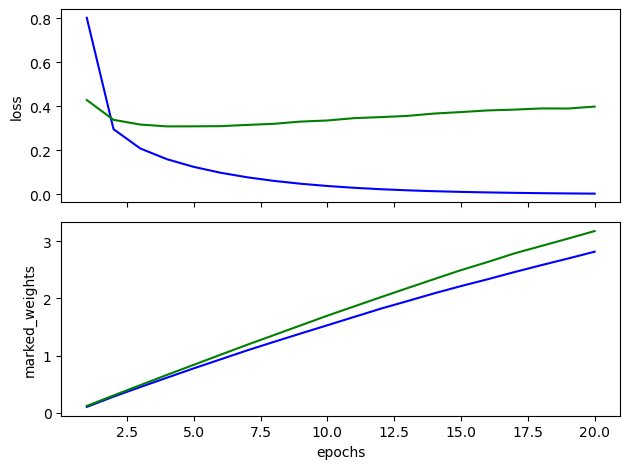

In [28]:
# Plot the value of the marked weights to visualize its behavior during training.
# Alongside the marked weights we will plot the train and validation loss.

train_loss = history0.history["loss"]
val_loss = history0.history["val_loss"]

# Initialize two plots sharing the x axis
fig, axs = plt.subplots(2, sharex=True, tight_layout=True)

# Generate the epochs range
epochs = range(1, num_epochs + 1)

# Plot train and validation losses in the first plot
axs[0].plot(epochs, train_loss, color = 'b')
axs[0].plot(epochs, val_loss, color = 'g')
axs[0].set(ylabel = 'loss')
# Plot two marked weights of your choice in the second plot
axs[1].plot(epochs, [w[0] for w in marked_ws0], color='b')
axs[1].plot(epochs, [w[3] for w in marked_ws0], color='g')
axs[1].set(xlabel = 'epochs', ylabel = 'marked_weights')

It is quite apparent that the model is learning to differentiate the digits using the markers we left in the training data and is not really learning much else.

#### With dropout (dropout_rate = 0.5, l1 = l2 = 0)

[Text(0.5, 0, 'epochs'), Text(0, 0.5, 'marked_weights')]

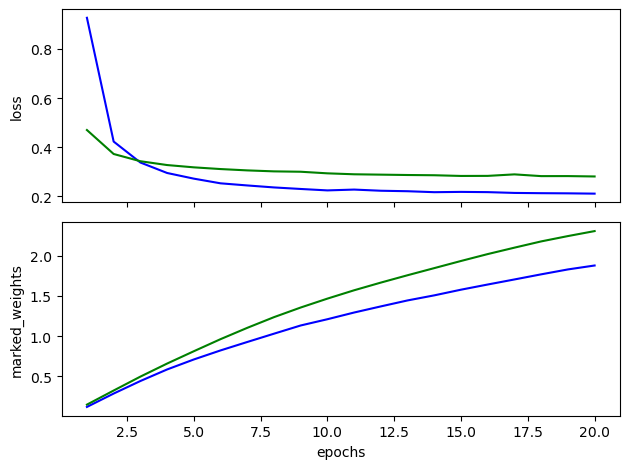

In [29]:
# Generate a model with only dropout turned on
mnist_marked_1 = mnist_marked(dropout_rate = 0.5, name = 'mnist_marked_1')

# Compile the model with our chosen optimizer, loss function and metrics
mnist_marked_1.compile(optimizer = optim0, loss = loss0, metrics = metrics0)

# Train the model for a few epochs and check how the marked weights behave
num_epochs = 20
batch_size = 256
marked_ws1 = []
history1 = mnist_marked_1.fit(train_images, train_labels,
                              validation_data = (val_images, val_labels),
                              epochs = num_epochs,
                              batch_size = batch_size,
                              callbacks = [pixel_callback(mnist_marked_1, marked_ws1)],
                              verbose = 0)


# Plot the value of the marked weights to visualize its behavior during training.
# Alongside the marked weights we will plot the train and validation loss.
train_loss = history1.history["loss"]
val_loss = history1.history["val_loss"]

# Initialize two plots sharing the x axis
fig, axs = plt.subplots(2, sharex=True, tight_layout=True)

# Generate the epochs range
epochs = range(1, num_epochs + 1)

# Plot train and validation losses in the first plot
axs[0].plot(epochs, train_loss, color = 'b')
axs[0].plot(epochs, val_loss, color = 'g')
axs[0].set(ylabel = 'loss')
# Plot two marked weights of your choice in the second plot
axs[1].plot(epochs, [w[0] for w in marked_ws1], color='b')
axs[1].plot(epochs, [w[3] for w in marked_ws1], color='g')
axs[1].set(xlabel = 'epochs', ylabel = 'marked_weights')

With dropout_rate = 0.5, each marking will only be present 50% of the time giving the model a chance to learn the true features of the images.

#### With dropout and L1L2 regularization

[Text(0.5, 0, 'epochs'), Text(0, 0.5, 'marked_weights')]

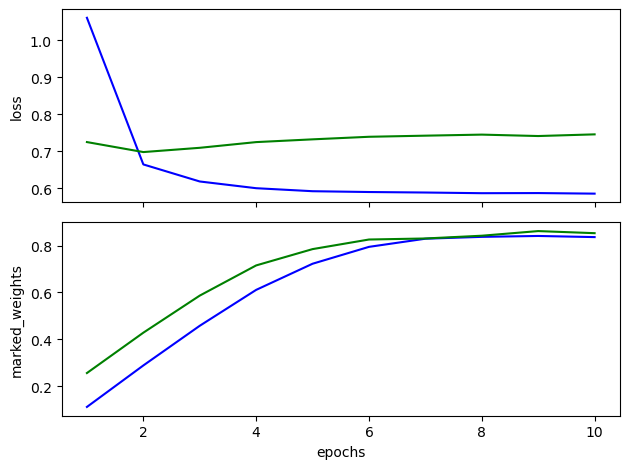

In [41]:
# Generate a model with dropout and regularization
mnist_marked_2 = mnist_marked(0.4, 0.0, 0.01, name = 'mnist_marked_1')

# Compile the model with our chosen optimizer, loss function and metrics
mnist_marked_2.compile(optimizer = optim0, loss = loss0, metrics = metrics0)

# Train the model for a few epochs and check how the marked weights behave
num_epochs = 10
batch_size = 256
marked_ws2 = []
history2 = mnist_marked_2.fit(train_images, train_labels,
                              validation_data = (val_images, val_labels),
                              epochs = num_epochs,
                              batch_size = batch_size,
                              callbacks = [pixel_callback(mnist_marked_2, marked_ws2)],
                              verbose = 0)


# Plot the value of the marked weights to visualize its behavior during training.
# Alongside the marked weights we will plot the train and validation loss.
train_loss = history2.history["loss"]
val_loss = history2.history["val_loss"]

# Initialize two plots sharing the x axis
fig, axs = plt.subplots(2, sharex=True, tight_layout=True)

# Generate the epochs range
epochs = range(1, num_epochs + 1)

# Plot train and validation losses in the first plot
axs[0].plot(epochs, train_loss, color = 'b')
axs[0].plot(epochs, val_loss, color = 'g')
axs[0].set(ylabel = 'loss')
# Plot two marked weights of your choice in the second plot
axs[1].plot(epochs, [w[2] for w in marked_ws2], color='b')
axs[1].plot(epochs, [w[3] for w in marked_ws2], color='g')
axs[1].set(xlabel = 'epochs', ylabel = 'marked_weights')

Clearly weight regularization prevents the unbounded growth of our marked weights. However, it is unfortunate that our model is too simple resulting in the regulizer limiting its learning capacity altogether. I encourage you to enhance the model by including a weight regularized hidden layer and tune its dropout and regularization parameters to mitigate the overfitting problem.